In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [2]:
import tensorflow as tf
print("Tensorflow:", tf.__version__)

import kerastuner as kt
print("kerastuner:", kt.__version__)

import keras_tuner as kt2
print("keras_tuner:", kt2.__version__)

import platform
print("Python:", platform.python_version())

import numpy as np
print("numpy:", np.__version__)

import pandas as pd
print("pandas:", pd.__version__)

import sklearn
print("sklearn version:", sklearn.__version__)

import sklearn
print("sklearn path:", sklearn.__path__)

import matplotlib
print("matplotlib:", matplotlib.__version__)

import seaborn as sns
print("seaborn:", sns.__version__)



Tensorflow: 2.15.0


C:\Users\Micha\AppData\Local\Temp\ipykernel_13360\1753711907.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


kerastuner: 1.0.5
keras_tuner: 1.3.5
Python: 3.10.11
numpy: 1.24.3
pandas: 2.1.4
sklearn version: 1.2.2
sklearn path: ['c:\\Users\\Micha\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\sklearn']
matplotlib: 3.8.2
seaborn: 0.13.0


## Set Global random seed to make sure we can replicate any model that we create (no randomness)

In [3]:
import random
import tensorflow as tf
import numpy as np
import os



np.random.seed(42)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

## **Load the Data from the Database**

In [4]:
#Remember to eventually clean up the wrong or missing values
train_data = pd.read_csv("train.csv")

#train_data.head()

In [5]:
#Remember to eventually clean up the wrong or missing values
test_data = pd.read_csv("test.csv")

#test_data.head()

## Set the target/label (y) values


In [6]:
#Y_train = pd.get_dummies(train_data["Survived"])
Y_train = train_data["Survived"]

#Y_train.head()


## Now I will re-initialize my data set and clean up my data before using pd.get_dummies()

**I set up X_train and Y_train, but this time, instead of doing pd.get_Dummies() on X_train, I'm not going to use pd.get_Dummies() until after I clean up the data**

In [7]:
train_data = pd.read_csv("train.csv")

features = ["Pclass", "Sex", "Fare","Age", "SibSp", "Parch"] # Here, I also added more features which I think might be useful


# print(train_data["Age"].isnull().sum())
# train_data = train_data.dropna(subset=["Age"]) # Drop the rows with missing values of age.
# print(train_data["Age"].isnull().sum())

# train_data = train_data.dropna(subset=["Embarked"]) # Drop the rows with missing values of Embarked
# print(train_data["Embarked"].isnull().sum())

X_train = train_data # I won't actually limit the X_train to just the columns of the features I want just yet. This is because I will use the other columns in the data set to help impute missing values

Y_train = train_data["Survived"]

#print(X_train.head())


## Start cleaning up the data

In [8]:
# Impute missing values for Pclass

average_Pclass = X_train["Pclass"].median()

X_train["Pclass"].fillna(average_Pclass, inplace = True)

print(X_train["Pclass"].isnull().sum()) # print the number of rows in the "Pclass" columns that now have no value

print(X_train["Sex"].isnull().sum()) # Since this prints out 0, this means that there is no missing value in the "Sex" column so we don't need to impute anything

print(X_train["Fare"].isnull().sum()) # Since this prints out 0, this means that there is no missing value in the "Fare" column so we don't need to impute anything

print(X_train["SibSp"].isnull().sum()) # Since this prints out 0, this means that there is no missing value in the "SibSp" column so we don't need to impute anything

print(X_train["Parch"].isnull().sum()) # Since this prints out 0, this means that there is no missing value in the "Parch" column so we don't need to impute anything

print(X_train["Age"].isnull().sum()) # This prints out 177 so there are 177 rows with missing values in the "Age" column! This means we have to do a lot of imputing


#print(X_train["Embarked"].isnull().sum())



0
0
0
0
0
177


**From this, we learned that age is the main column with missing values (of the columns that we are working with) so we need to methodically impute those missing values**

## Cleaning up (imputing) the Age column using a Random Forest Regressor model (a type of Machine Learning model) that accurately predicts the age of a person given their information


I made it so that when ever you run this code, it will check to see if there is already imputed data (inside of the csv) and if there is, then the imputer won't run since it takes a long time and if the imputed already exists (from previous runs), then there's no point in running the imputer again (which is what I did before and it wasted so much time)

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

imputed_csv_path = 'X_train_imputed.csv'

if not os.path.exists(imputed_csv_path):
    # If CSV doesn't exist, run the imputation and save the results
   #We use "LabelEncoder" to turn all the categorial values (values which don't use numbers) into values which the Random Forest Regressor can understand more easily. This is very similar to doing something like pd.get_dummies()

    label_encoders = {}
    for column in ['Sex', 'Embarked']:
        label_encoders[column] = LabelEncoder()
        # We use 'astype(str)' to convert any NaN values to a string representation
        X_train[column] = label_encoders[column].fit_transform(X_train[column].astype(str))

    features = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    # One very important thing that I will end up doing is using the "Survived" column of the dataset to predict the age. This is because there is a strong correleation between the survival and age. 


    #This is an imputer. It is a function that can efficiently impute values in the way you want. For this scenario, I am using IterativeImputer() and the RandomForestRegressor(() to )
    imputer = IterativeImputer(RandomForestRegressor(n_estimators=10), max_iter=100, random_state=42)


    # Fit the imputer on the DataFrame with the features
    imputer.fit(X_train[features]) #When IterativeImputer is used alongside an ML model like RandomForestRegressor, calling .fit() on the IterativeImputer() object will also fit (train) the ML model


    # Perform the imputation on the Training Data. THIS WILL ACTUAL IMPUTE ANY MISSING VALUES IN EACH ROW, not only the missing values in Age.
    X_train_imputed = imputer.transform(X_train[features])


    # Convert the output back to a DataFrame
    X_train_imputed = pd.DataFrame(X_train_imputed, columns=features)

    # Update the original DataFrame with the imputed values. This means that the columns of the original X_train dataframe that weren't part of the features (like "Name" isn't apart of the features list)
    X_train[features] = X_train_imputed

    #print(X_train.head())


    # Save the imputed DataFrame to CSV
    X_train.to_csv(imputed_csv_path, index=False)
    print("I did imputation again")

else:
    # Load the imputed data from the CSV file
    X_train = pd.read_csv(imputed_csv_path)
    print("I used the data from the csv")
 

I used the data from the csv


**Using the ImperativeImputer(), this will actually impute all the missing values in each row. It won't only impute the missing values in the "age" column. BUT, since we already cleaned the data and know there are 0 missing values for all the other columns that we care about (the ones with the features we are using), the imputer will be imputing values only to the missing values of age and other columns that we don't care about, but out of all the columns we care about, it will only be affecting the age column since all the other columns we care about have 0 missing values as we checked in the code previously.**

In [10]:
features = ["Pclass", "Sex", "Fare","Age", "SibSp", "Parch"]

X_train = X_train[features]

#print(X_train.head(5))

#print((X_train["Sex"] == 0).sum())
#print((X_train["Sex"] == 1).sum())

# Since the dataset is 65% male, we can see from printing out the number of people with "sex equal to 0" and "sex equal to 1" that the LabelEncoder made Male into "1" and Female into "0". Now, let's change it back to "Male" and "Female".


# Check if 'Sex' column contains numeric values
if np.issubdtype(X_train['Sex'].dtype, np.number):
    # If 'Sex' column is numeric, map 0 to 'female' and 1 to 'male'
    X_train['Sex'] = X_train['Sex'].map({0: 'female', 1: 'male'})

    

if "Embarked" in features:
    X_train["Embarked"] = X_train["Embarked"].astype("category")
    X_train["Embarked"] = X_train["Embarked"].cat.codes

print(X_train)

     Pclass     Sex     Fare   Age  SibSp  Parch
0       3.0    male   7.2500  22.0    1.0    0.0
1       1.0  female  71.2833  38.0    1.0    0.0
2       3.0  female   7.9250  26.0    0.0    0.0
3       1.0  female  53.1000  35.0    1.0    0.0
4       3.0    male   8.0500  35.0    0.0    0.0
..      ...     ...      ...   ...    ...    ...
886     2.0    male  13.0000  27.0    0.0    0.0
887     1.0  female  30.0000  19.0    0.0    0.0
888     3.0  female  23.4500  24.8    1.0    2.0
889     1.0    male  30.0000  26.0    0.0    0.0
890     3.0    male   7.7500  32.0    0.0    0.0

[891 rows x 6 columns]


**Here, in the code above, I changed X_train back to focus only on the features we care about. I also changed the "Sex" column from 0 and 1 back to Male and Female.**

## After the careful inspection of the test.csv, I see that there are also missing values in the test.csv. As a result, we have to clean up the data for test.csv as we did for train.csv

**Seeing which columns have missing values:**

In [11]:
test_data = pd.read_csv("test.csv")

features = ["Pclass", "Sex", "Fare","Age", "SibSp", "Parch"]

print(test_data["Pclass"].isnull().sum()) # Since this is 0, that means there is no missing values

print(test_data["Sex"].isnull().sum()) # Since this is 0, that means there is no missing values

print(test_data["SibSp"].isnull().sum()) # Since this is 0, that means there is no missing values

print(test_data["Parch"].isnull().sum()) # Since this is 0, that means there is no missing values

print(test_data["Fare"].isnull().sum()) # Since this is 1, that means there is one missing value

print(test_data["Age"].isnull().sum()) # Since this is 86, that means there are 86 missing values


0
0
0
0
1
86


**From this, we can see that only "Fare" annd "Age" have missing values. Since "Fare" only has one missing value, it's not worth it to go to through all the work to do some advanced imputation technique to fill in missing values. So, I will just fill that in with the average fare value.**

**For the "Age" feature, I will repeat the process of using an IterativeImputer and a RandomForestRegressor to imputate missing values**

In [12]:
average_fare = test_data["Fare"].mean()

test_data["Fare"].fillna(average_fare, inplace = True) # This replaces the single missing value in "Fare" with the average value Fare Value of the test data

print(test_data["Fare"].isnull().sum())

print(test_data["Age"].isnull().sum())

0
86


I made it so that when ever you run this code, it will check to see if there is already imputed data (inside of the csv) and if there is, then the imputer won't run since it takes a long time and if the imputed already exists (from previous runs), then there's no point in running the imputer again (which is what I did before and it wasted so much time)

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Your imputation code setup here...

# Path to the imputed CSV file
imputed_csv_path = 'test_data_imputed.csv'

# Check if the imputed data CSV file exists
if not os.path.exists(imputed_csv_path):
    # If CSV doesn't exist, run the imputation and save the results
    #We use "LabelEncoder" to turn all the categorial values (values which don't use numbers) into values which the Random Forest Regressor can understand more easily. This is very similar to doing something like pd.get_dummies()

    label_encoders = {}
    for column in ['Sex', 'Embarked']:
        label_encoders[column] = LabelEncoder()
        # We use 'astype(str)' to convert any NaN values to a string representation
        test_data[column] = label_encoders[column].fit_transform(test_data[column].astype(str))

    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


    #This is an imputer. It is a function that can efficiently impute values in the way you want. For this scenario, I am using IterativeImputer() and the RandomForestRegressor(() to )
    imputer = IterativeImputer(RandomForestRegressor(n_estimators=10), max_iter=100, random_state=42)


    # Fit the imputer on the DataFrame with the features
    imputer.fit(test_data[features]) #When IterativeImputer is used alongside an ML model like RandomForestRegressor, calling .fit() on the IterativeImputer() object will also fit (train) the ML model


    # Perform the imputation on the Test Data. THIS WILL ACTUAL IMPUTE ANY MISSING VALUES IN EACH ROW, not only the missing values in Age.
    test_data_imputed = imputer.transform(test_data[features])


    # Convert the output back to a DataFrame
    test_data_imputed = pd.DataFrame(test_data_imputed, columns=features)

    # Update the original DataFrame with the imputed values. This means that the columns of the original test_data dataframe that weren't part of the features (like "Name" isn't apart of the features list)
    test_data[features] = test_data_imputed

    print(test_data["Age"].isnull().sum()) # Since this prints 0, we now know that there are 0 missing values in the age column and so the imputation was successful 

    print(test_data.head())

    # Save the imputed DataFrame to CSV
    test_data.to_csv(imputed_csv_path, index=False)

    print("I created a new CSV file with imputation")


else:
    # Load the imputed data from the CSV file
    test_data = pd.read_csv(imputed_csv_path)

    print("I used imputated data from previous csv")

print(test_data["Age"].isnull().sum()) # Since this prints 0, we now know that there are 0 missing values in the age column and so the imputation was successful 


I used imputated data from previous csv
0


**The code above will imputate all the missing values in the test_data**

## Finalize the cleaning of the data and make it so test_data only has the features we want

In [14]:
features = ["Pclass", "Sex", "Fare","Age", "SibSp", "Parch"]

test_data = test_data[features]

#print((test_data["Sex"] == 0).sum())
#print((test_data["Sex"] == 1).sum())

# Since the dataset is 65% male, we can see from printing out the number of people with "sex equal to 0" and "sex equal to 1" that the LabelEncoder made Male into "1" and Female into "0". Now, let's change it back to "male" and "female".

test_data['Sex'] = test_data['Sex'].map({0: 'female', 1: 'male'})

if "Embarked" in features:
    test_data["Embarked"] = test_data["Embarked"].astype("category")
    test_data["Embarked"] = test_data["Embarked"].cat.codes


print(test_data)

#print((test_data["Sex"] == "male").sum())

     Pclass     Sex      Fare        Age  SibSp  Parch
0       3.0    male    7.8292  34.500000    0.0    0.0
1       3.0  female    7.0000  47.000000    1.0    0.0
2       2.0    male    9.6875  62.000000    0.0    0.0
3       3.0    male    8.6625  27.000000    0.0    0.0
4       3.0  female   12.2875  22.000000    1.0    1.0
..      ...     ...       ...        ...    ...    ...
413     3.0    male    8.0500  26.892143    0.0    0.0
414     1.0  female  108.9000  39.000000    0.0    0.0
415     3.0    male    7.2500  38.500000    0.0    0.0
416     3.0    male    8.0500  26.892143    0.0    0.0
417     3.0    male   22.3583  12.815000    1.0    1.0

[418 rows x 6 columns]


## Now, after cleaning up the data, I can split up the data into train_validation_test 

In [15]:
from sklearn.model_selection import train_test_split

#Y_train = train_data["Survived"]

# First, split into training (60%) and a test set (40%)
train_X, test_X, train_Y, test_Y = train_test_split(X_train, Y_train, test_size=0.4, random_state = 42)

#Second, split test set into a validation (20%) and test set (20%)
valid_X, test_X, valid_Y, test_Y= train_test_split(test_X, test_Y, test_size = 0.5, random_state = 42)

## Using pd.get_dummies() on all the data

**Setting up the Test data (from Test.csv) (This is NOT the test data from the Train_validation_test split):**

In [16]:


test_data = pd.get_dummies(test_data)
#print(test_data.head())

**Setting up the Train data and Validation data and the Test data from the train_validation_test split:**

In [17]:
train_X = pd.get_dummies(train_X)
#print(train_X.head())

valid_X = pd.get_dummies(valid_X)
#print(valid_X.head())

test_X = pd.get_dummies(test_X)
#print(test_X.head())

## Feature Engineering: Putting more weight onto specific features (like Gender and Age)

**We know from history that Women and Children were more likely to survive so it makes more sense to put more weight into those features. In other words, we should penalize a person more if they are not a Women or Child and therefore make it less likely for them to survive**

In [18]:
#print(train_X)

child_age = 18 # Age 7: 0.03, 0.16, Age 8: 0.03, 0.15. Age 9: 0.03, 0.14. Age 10: 0.03, 0.10. Age 16: 0.08, 0.11. 

#Create a FemaleFirstClass and ChildFirstClass feature into each dataset
train_X['FemaleFirstClass'] = ((train_X['Sex_female'] == True) & (train_X['Pclass'] == 1)).astype(int)
#train_X['ChildFirstClass'] = ((train_X['Age'] < child_age) & (train_X['Pclass'] == 1)).astype(int) 


valid_X['FemaleFirstClass'] = ((valid_X['Sex_female'] == True) & (valid_X['Pclass'] == 1)).astype(int)
#valid_X['ChildFirstClass'] = ((valid_X['Age'] < child_age) & (valid_X['Pclass'] == 1)).astype(int) 


test_X['FemaleFirstClass'] = ((test_X['Sex_female'] == True) & (test_X['Pclass'] == 1)).astype(int)
#test_X['ChildFirstClass'] = ((test_X['Age'] < child_age) & (test_X['Pclass'] == 1)).astype(int) 


test_data['FemaleFirstClass'] = ((test_data['Sex_female'] == True) & (test_data['Pclass'] == 1)).astype(int)
#test_data['ChildFirstClass'] = ((test_data['Age'] < child_age) & (test_data['Pclass'] == 1)).astype(int) 


# Bin 'Age' into categories
# train_X['IsChild'] = (train_X['Age'] < child_age).astype(int)
# valid_X['IsChild'] = (valid_X['Age'] < child_age).astype(int)
# test_X['IsChild'] = (test_X['Age'] < child_age).astype(int)
# test_data['IsChild'] = (test_data['Age'] < child_age).astype(int)


#Create FamilySize and IsAlone
train_X['FamilySize'] = train_X['SibSp'] + train_X['Parch'] + 1
valid_X['FamilySize'] = valid_X['SibSp'] + valid_X['Parch'] + 1
test_X['FamilySize'] = test_X['SibSp'] + test_X['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1


train_X['IsAlone'] = (train_X['FamilySize'] == 1).astype(int)
valid_X['IsAlone'] = (valid_X['FamilySize'] == 1).astype(int)
test_X['IsAlone'] = (test_X['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)


#print(train_X)

## Normalizing all the data

**Creating the Normalizing Scaler**

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select columns you want to normalize
columns_to_normalize = ["Pclass", "Fare","Age", "SibSp"]

scaler.fit(train_X[columns_to_normalize]) #it is important to fit the scaler on the training data (from the train-validation-test split) only

# print(train_X)

MinMaxScaler()

**It is very important to only fit the scaler on the training data from the train-validation-test split and not the training data from the whole train.csv since the whole training data includes data from the validation and test split and fitting on that will cause the testing (using validation and test) of the model to be overly optimistic. This is called data leakage.**

**Also, it's important that we do not fit the scaler multiple times since that would cause inconsistant fitting throughout the data. It should only be fitted once and then applied to all the different datasets.**

**However,before I submit Model 4, I should re-fit the normalization scaler on the entire training data since I will be running my model on the entire training data**

**Normalizing the test data (the one from test.csv)**

In [20]:
test_data = test_data #the "test_data" variable here is after we cleaned up the test_data 

#print(test_data)

# Fit the scaler on the data and then transform it
test_data[columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])

#print(test_data)

**Normalizing the train, validation, and test data**

In [21]:
train_X[columns_to_normalize] = scaler.transform(train_X[columns_to_normalize])
#print(train_X.head())

valid_X[columns_to_normalize] = scaler.transform(valid_X[columns_to_normalize])
#print(valid_X.head())

test_X[columns_to_normalize] = scaler.transform(test_X[columns_to_normalize])
#print(test_X.head())

#print(train_X)

## I should re-fit the normalization scaler on the entire training data since I will be running my model on the entire training data


In [22]:
from sklearn.preprocessing import MinMaxScaler

training_X = pd.concat([train_X, valid_X, test_X], ignore_index=True) # training_X is the entire training data from train.csv but after all the cleaning, normalization, and feature engineering
training_Y = pd.concat([train_Y, valid_Y, test_Y], ignore_index=True) 


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

columns_to_normalize = ["Pclass", "Fare", "Age", "SibSp"]

scaler.fit(training_X[columns_to_normalize])

#print(training_X)

training_X[columns_to_normalize] = scaler.transform(training_X[columns_to_normalize])

#print(training_X)

## MAKE SURE THERE ISN'T ANY NEGATIVE VALUES FOR AGE BEFORE AND AFTER NORMALIZATION

In [23]:
negatives = training_X[training_X["Age"] < 0]
#print(negatives)

# No values negative values for age

## Try TensorFlow Neural Network Model

**Change all the data to float32 so that it can be converted into tensor**

In [24]:
train_X = train_X.astype('float32')
valid_X = valid_X.astype('float32')
test_X = test_X.astype('float32')
training_X = training_X.astype('float32')
training_X2 = training_X.astype('float32')

test_data2 = test_data.astype('float32')

In [25]:
# import tensorflow as tf
# print(tf.__version__)

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from sklearn.model_selection import train_test_split


# # train_X = train_X.values
# # valid_X = valid_X.values
# # train_Y = train__Y.values
# # valid_Y = valid_Y.values


# model_tensor = Sequential([
#     Dense(64, activation='relu', input_shape=(train_X.shape[1],)),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])


# model_tensor.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# history = model_tensor.fit(train_X, train_Y, epochs=100, validation_split=0.2, verbose=0)

# loss, accuracy = model_tensor.evaluate(valid_X, valid_Y)

# print(f"Test Accuracy: {accuracy}")

# predictionz = model_tensor.predict(valid_X)
#print(predictionz)

#print(tf.__version__)

## Using Keras Tuner, which is TensorFlow's version of GridSearchCV, in order to find the best hyperparamters for my model

In [26]:
# import keras_tuner as kt



# def build_model(hp):
#     model = tf.keras.Sequential()
    
#     model.add(tf.keras.layers.Dense(
#         units=hp.Int('units', min_value=10, max_value=64, step=4),
#         activation='relu',
#         input_shape=(train_X.shape[1],)
#     ))
    
#     model.add(tf.keras.layers.Dense(
#         units=hp.Int('units', min_value=10, max_value=64, step=4),
#         activation='relu'
#     ))
    
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(
#             hp.Choice('learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001])),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])
    
#     # model.compile(
#     # optimizer=tf.keras.optimizers.Adam(
#     #     learning_rate=hp.Choice('learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001]),
#     #     beta_1=0.9,
#     #     beta_2=0.999,
#     #     epsilon=1e-07,
#     #     amsgrad=False),
#     # loss='binary_crossentropy',
#     # metrics=['accuracy'])
    
#     return model

# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=100,
#     directory='my_dir',
#     project_name='keras_tuner_demo') #MAKE SURE TO CHANGE THE PROJECT NAME TO START A FRESH NEW TUNING SESSION IF YOU WANT TO TRY A NEW SET OF PARAMETERS

# tuner.search(pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_Y, valid_Y], ignore_index=True), epochs=100, validation_data=(test_X, test_Y)) 
# #tuner.search(train_X, train_Y, epochs=100, validation_data=(valid_X, valid_Y))

# # Get the best model
# best_model = tuner.get_best_models()[0]

## Show information about the model from Keras Tuner

In [27]:
# #1 Summary of the model: This will print a summary of the model's layers, output shapes, and the number of parameters.
# print("Summary of Model: ")
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.summary()

# #2 Inspect Hyperparameters: This will display the values of the hyperparameters like the number of units in each layer, learning rate, etc.
# print("Hyperparameters: ")
# best_hp = tuner.get_best_hyperparameters()[0]
# for param in best_hp.values:
#     print(param, best_hp.get(param))

    
# #3 Model Configuration: This returns a Python dictionary containing the model configuration. It can be quite detailed and technical, showing layer types, activation functions, and other layer-specific settings.
# print("Model Configuration: ")
# config = best_model.get_config()


# #4 Visualizing the Model: This creates a plot of the model architecture, showing the layers, their shapes, and how they're connected.
# print("Visualizing the model: ")
# tf.keras.utils.plot_model(best_model, to_file='model.png', show_shapes=True, show_layer_names=True) # This is downloaded in the kaggle output file


# #5 Weights and Biases: This will print out the weights and biases for each layer in the model. Be cautious with large models, as this can be a lot of data.
# print("Weights and Biases: ")
# # for layer in best_model.layers:
# #     weights, biases = layer.get_weights()
# #     print(layer.name, weights, biases)






## Testing my new Model (7) from the Keras Tuner

In [28]:
# model7 = best_model #it's already had .fit() ran on it (inside Keras Tuner) so I don't have to do it 

# test_X = test_X.astype('float32')

# loss, accuracy = model_tensor.evaluate(test_X, test_Y) #This won't actually work because the test data was used in the keras tuner 

# print(f"Test Accuracy: {accuracy}")


## Submitting model 7

In [29]:
# # Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters()[0]

# # Rebuild the model with the best hyperparameters
# model7 = build_model(best_hp)   # I have to re-build the model since I have to re-fit on the whole training data (training_X2) 

# #model7 = best_model

# # Fit the model on the entire training dataset

# model7.fit(training_X2, training_Y, epochs=200, validation_split=0.3, verbose=0)

# if "PassengerId" in test_data2.columns:
#     test_data2 = test_data2.drop("PassengerId", axis = 1)

# predictions7 = model7.predict(test_data2)

# predictions7 = (predictions7 > 0.6).astype("int32")

# original_test = pd.read_csv("test.csv")

# pass_id = original_test['PassengerId']

# test_data2["PassengerId"] = pass_id

# #Flatten out predictions so that we make sure it's a 1D array

# predictions7 = predictions7.reshape(-1)

# output = pd.DataFrame({'PassengerId': test_data2.PassengerId, 'Survived': predictions7})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

# test_data2 = test_data2.drop("PassengerId", axis = 1) # WE make sure to drop the PassengerId column since we are continuing to use the test_data variable in future tests and we don't want PassengerId to be apart of it until we submit the model again

## Changing the Keras Tuner to allow for more parameters because it's so fast

In [30]:
# import keras_tuner as kt

# def build_model(hp):
#     model = tf.keras.Sequential()
    
#     # Input layer
#     model.add(tf.keras.layers.Dense(
#         units=hp.Int('input_units', min_value=5, max_value=64, step=1),
#         activation=hp.Choice('input_activation', ['relu', 'tanh', 'sigmoid']),
#         input_shape=(train_X.shape[1],)
#     ))
    
#     # Hidden layers
#     for i in range(hp.Int('n_layers', 1, 5)):
#         model.add(tf.keras.layers.Dense(
#             units=hp.Int(f'hidden_units_{i}', min_value=5, max_value=64, step=1),
#             activation=hp.Choice(f'hidden_activation_{i}', ['relu', 'tanh', 'sigmoid']),
#             kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'regularization_{i}', min_value=0.0, max_value=0.1, step=0.01))
#         ))
    
#     # Output layer
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
#     # Compile the model
#     model.compile(
#         optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])
    
#     return model

# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=100,
#     directory='directory_for_model_8',
#     project_name='keras_tuner_model8',
#     hyperband_iterations=2)  # Increase if you have more time

# # Search for the best hyperparameters
# tuner.search(pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_Y, valid_Y], ignore_index=True), 
#              epochs=100, 
#              validation_data=(test_X, test_Y), 
#              batch_size=32)  # Fixed batch size

# # Get the best model
# best_model = tuner.get_best_models()[0]

# # This model took 508 trials and almost 10 minutes to run

#Hyper parameters:
# input_units 21
# input_activation relu
# n_layers 3
# hidden_units_0 11
# hidden_activation_0 tanh
# regularization_0 0.1
# optimizer adam
# hidden_units_1 59
# hidden_activation_1 relu
# regularization_1 0.0
# hidden_units_2 11
# hidden_activation_2 tanh
# regularization_2 0.0
# hidden_units_3 20
# hidden_activation_3 relu
# regularization_3 0.06
# hidden_units_4 33
# hidden_activation_4 tanh
# regularization_4 0.09
# tuner/epochs 100
# tuner/initial_epoch 34
# tuner/bracket 3
# tuner/round 3
# tuner/trial_id 0461

In [31]:
# #1 Summary of the model: This will print a summary of the model's layers, output shapes, and the number of parameters.
# print("Summary of Model: ")
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.summary()

# #2 Inspect Hyperparameters: This will display the values of the hyperparameters like the number of units in each layer, learning rate, etc.
# print("Hyperparameters: ")
# best_hp = tuner.get_best_hyperparameters()[0]
# for param in best_hp.values:
#     print(param, best_hp.get(param))

    
# #3 Model Configuration: This returns a Python dictionary containing the model configuration. It can be quite detailed and technical, showing layer types, activation functions, and other layer-specific settings.
# print("Model Configuration: ")
# #config = best_model.get_config()


# #4 Visualizing the Model: This creates a plot of the model architecture, showing the layers, their shapes, and how they're connected.
# print("Visualizing the model: ")
# tf.keras.utils.plot_model(best_model, to_file='model.png', show_shapes=True, show_layer_names=True) # This is downloaded in the kaggle output file


# #5 Weights and Biases: This will print out the weights and biases for each layer in the model. Be cautious with large models, as this can be a lot of data.
# print("Weights and Biases: ")
# # for layer in best_model.layers:
# #     weights, biases = layer.get_weights()
# #     print(layer.name, weights, biases)






In [32]:
# model8 = best_model #it's already had .fit() ran on it (inside Keras Tuner) so I don't have to do it 

# test_X = test_X.astype('float32')

# loss, accuracy = model_tensor.evaluate(test_X, test_Y)

# print(f"Test Accuracy: {accuracy}")


## Submitting model 8 (Score: 78.8)

In [33]:
# # Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters()[0]

# # Rebuild the model with the best hyperparameters
# #model8 = build_model(best_hp)   # I have to re-build the model since I have to re-fit on the whole training data (training_X2) 

# #Or, another thing you can do is just use the best model from the keras tuner instead of re-fitting it on the full training data
# model8 = best_model

# # Fit the model on the entire training dataset

# #model8.fit(training_X2, training_Y, epochs=200, validation_split=0.2, verbose=0)

# if "PassengerId" in test_data2.columns:
#     test_data2 = test_data2.drop("PassengerId", axis = 1)

# predictions8 = model8.predict(test_data2)

# predictions8 = (predictions8 > 0.5).astype("int32")

# original_test = pd.read_csv("test.csv")

# pass_id = original_test['PassengerId']

# test_data2["PassengerId"] = pass_id

# #Flatten out predictions so that we make sure it's a 1D array

# predictions8 = predictions8.reshape(-1)

# output = pd.DataFrame({'PassengerId': test_data2.PassengerId, 'Survived': predictions8})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

# test_data2 = test_data2.drop("PassengerId", axis = 1) # WE make sure to drop the PassengerId column since we are continuing to use the test_data variable in future tests and we don't want PassengerId to be apart of it until we submit the model again

## Change the keras tuner even more and add validation split and drop out to make sure it doesn't over fit

In [34]:
# import keras_tuner as kt

# def build_model(hp):
#     model = tf.keras.Sequential()
    
#     # Input layer
#     model.add(tf.keras.layers.Dense(
#         units=hp.Int('input_units', min_value=5, max_value=64, step=1),
#         activation=hp.Choice('input_activation', ['relu', 'tanh', 'sigmoid']),
#         input_shape=(train_X.shape[1],)
#     ))
    
#     # Hidden layers
#     for i in range(hp.Int('n_layers', 1, 5)):
#         model.add(tf.keras.layers.Dense(
#             units=hp.Int(f'hidden_units_{i}', min_value=5, max_value=64, step=1),
#             activation=hp.Choice(f'hidden_activation_{i}', ['relu', 'tanh', 'sigmoid']),
#             kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'regularization_{i}', min_value=0.0, max_value=0.1, step=0.01))
#         ))
#         # Dropout layer
#         model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    
#     # Output layer
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
#     # Compile the model
#     model.compile(
#         optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])
    
#     return model

# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=100,
#     directory='directory_for_model_9',  #Make sure to change ethe directory  and project name if you want to start a fresh new tuning session
#     project_name='keras_tuner_model9', # make sure to change the project and directory name if you want to start a fresh new tuning session
#     hyperband_iterations=2)  # Increase if you have more time

# # Search for the best hyperparameters
# tuner.search(pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_Y, valid_Y], ignore_index=True), 
#              epochs=100, 
#              validation_split=0.2,  # 20% of the data will be used for validation
#              batch_size=32)  # Fixed batch size

# # Get the best model
# best_model = tuner.get_best_models()[0]

# #This took 12 minutes for the code to run. 507 trials

# # input_units 54
# # input_activation relu
# # n_layers 3
# # hidden_units_0 30
# # hidden_activation_0 relu
# # regularization_0 0.1
# # dropout_rate 0.4
# # optimizer rmsprop
# # hidden_units_1 49
# # hidden_activation_1 relu
# # regularization_1 0.0
# # hidden_units_2 58
# # hidden_activation_2 relu
# # regularization_2 0.0
# # hidden_units_3 60
# # hidden_activation_3 relu
# # regularization_3 0.03
# # hidden_units_4 43
# # hidden_activation_4 sigmoid
# # regularization_4 0.06
# # tuner/epochs 100
# # tuner/initial_epoch 34
# # tuner/bracket 2
# # tuner/round 2
# # tuner/trial_id 0484
# # Model Configuration: 
# # Visualizing the model: 
# # Weights and Biases: 
# # Optimizer: 
# # {'name': 'RMSprop', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': 100, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}

In [35]:
# #1 Summary of the model: This will print a summary of the model's layers, output shapes, and the number of parameters.
# print("Summary of Model: ")
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.summary()

# #2 Inspect Hyperparameters: This will display the values of the hyperparameters like the number of units in each layer, learning rate, etc.
# print("Hyperparameters: ")
# best_hp = tuner.get_best_hyperparameters()[0]
# for param in best_hp.values:
#     print(param, best_hp.get(param))

    
# #3 Model Configuration: This returns a Python dictionary containing the model configuration. It can be quite detailed and technical, showing layer types, activation functions, and other layer-specific settings.
# print("Model Configuration: ")
# config = best_model.get_config()


# #4 Visualizing the Model: This creates a plot of the model architecture, showing the layers, their shapes, and how they're connected.
# print("Visualizing the model: ")  # MAKE
# tf.keras.utils.plot_model(best_model, to_file='model9.png', show_shapes=True, show_layer_names=True) # MAKE SURE TO CHANGE THE FILE NAME 


# #5 Weights and Biases: This will print out the weights and biases for each layer in the model. Be cautious with large models, as this can be a lot of data.
# print("Weights and Biases: ")
# # for layer in best_model.layers:
# #     weights, biases = layer.get_weights()
# #     print(layer.name, weights, biases)


# #6 see the best optimizer specifically 
# print("Optimizer: ")
# # Get the optimizer's configuration
# optimizer_config = best_model.optimizer.get_config()

# # Print the optimizer configuration
# print(optimizer_config)


## Submitting Model 9 (validation split and drop out, along with more search space in keras tuner). Score: 78.708

In [36]:
# # Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters()[0]

# # Rebuild the model with the best hyperparameters
# #model9 = build_model(best_hp)   # I have to re-build the model since I have to re-fit on the whole training data (training_X2) 

# #Or, another thing you can do is just use the best model from the keras tuner instead of re-fitting it on the full training data
# model9 = best_model

# # Fit the model on the entire training dataset

# #model9.fit(training_X2, training_Y, epochs=100, validation_split=0.2, verbose=0)

# if "PassengerId" in test_data2.columns:
#     test_data2 = test_data2.drop("PassengerId", axis = 1)

# predictions9 = model9.predict(test_data2)

# predictions9 = (predictions9 > 0.72).astype("int32") 

# original_test = pd.read_csv("test.csv")

# pass_id = original_test['PassengerId']

# test_data2["PassengerId"] = pass_id

# #Flatten out predictions so that we make sure it's a 1D array

# predictions9 = predictions9.reshape(-1)

# output = pd.DataFrame({'PassengerId': test_data2.PassengerId, 'Survived': predictions9})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

# test_data2 = test_data2.drop("PassengerId", axis = 1) # WE make sure to drop the PassengerId column since we are continuing to use the test_data variable in future tests and we don't want PassengerId to be apart of it until we submit the model again

## Try removing the rows of data with missing age and then redoing keras tuner

In [37]:
# import keras_tuner as kt

# def build_model(hp):
#     model = tf.keras.Sequential()
    
#     # Input layer
#     model.add(tf.keras.layers.Dense(
#         units=hp.Int('input_units', min_value=5, max_value=64, step=1),
#         activation=hp.Choice('input_activation', ['relu', 'tanh', 'sigmoid']),
#         input_shape=(train_X.shape[1],)
#     ))
    
#     # Hidden layers
#     for i in range(hp.Int('n_layers', 1, 5)):
#         model.add(tf.keras.layers.Dense(
#             units=hp.Int(f'hidden_units_{i}', min_value=5, max_value=64, step=1),
#             activation=hp.Choice(f'hidden_activation_{i}', ['relu', 'tanh', 'sigmoid']),
#             kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'regularization_{i}', min_value=0.0, max_value=0.1, step=0.01))
#         ))
#         # Dropout layer
#         model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    
#     # Output layer
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
#     # Compile the model
#     model.compile(
#         optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])
    
#     return model

# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=100,
#     directory='directory_for_model_10',  #Make sure to change ethe directory  and project name if you want to start a fresh new tuning session
#     project_name='keras_tuner_model10', # make sure to change the project and directory name if you want to start a fresh new tuning session
#     hyperband_iterations=2)  # Increase if you have more time

# # Search for the best hyperparameters
# tuner.search(pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_Y, valid_Y], ignore_index=True), 
#              epochs=100, 
#              validation_split=0.2,  # 20% of the data will be used for validation
#              batch_size=32)  # Fixed batch size

# # Get the best model
# best_model = tuner.get_best_models()[0]

# # Took 10 minutes and 38 seconds

# # Hyperparameters: 
# # input_units 31
# # input_activation relu
# # n_layers 1
# # hidden_units_0 16
# # hidden_activation_0 tanh
# # regularization_0 0.0
# # dropout_rate 0.1
# # optimizer adam
# # hidden_units_1 49
# # hidden_activation_1 relu
# # regularization_1 0.09
# # hidden_units_2 36
# # hidden_activation_2 relu
# # regularization_2 0.04
# # hidden_units_3 26
# # hidden_activation_3 sigmoid
# # regularization_3 0.09
# # hidden_units_4 15
# # hidden_activation_4 sigmoid
# # regularization_4 0.06
# # tuner/epochs 100
# # tuner/initial_epoch 34
# # tuner/bracket 3
# # tuner/round 3
# # tuner/trial_id 0206
# # Model Configuration: 
# # Visualizing the model: 
# # Weights and Biases: 
# # Optimizer: 
# # {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}

In [38]:
# #1 Summary of the model: This will print a summary of the model's layers, output shapes, and the number of parameters.
# print("Summary of Model: ")
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.summary()

# #2 Inspect Hyperparameters: This will display the values of the hyperparameters like the number of units in each layer, learning rate, etc.
# print("Hyperparameters: ")
# best_hp = tuner.get_best_hyperparameters()[0]
# for param in best_hp.values:
#     print(param, best_hp.get(param))

    
# #3 Model Configuration: This returns a Python dictionary containing the model configuration. It can be quite detailed and technical, showing layer types, activation functions, and other layer-specific settings.
# print("Model Configuration: ")
# config = best_model.get_config()


# #4 Visualizing the Model: This creates a plot of the model architecture, showing the layers, their shapes, and how they're connected.
# print("Visualizing the model: ")  # MAKE
# tf.keras.utils.plot_model(best_model, to_file='model10.png', show_shapes=True, show_layer_names=True) # MAKE SURE TO CHANGE THE FILE NAME 


# #5 Weights and Biases: This will print out the weights and biases for each layer in the model. Be cautious with large models, as this can be a lot of data.
# print("Weights and Biases: ")
# # for layer in best_model.layers:
# #     weights, biases = layer.get_weights()
# #     print(layer.name, weights, biases)


# #6 see the best optimizer specifically 
# print("Optimizer: ")
# # Get the optimizer's configuration
# optimizer_config = best_model.optimizer.get_config()

# # Print the optimizer configuration
# print(optimizer_config)


## Submitting model 10 (the model that deleted the training data with missing age). Score: 77.5

In [39]:
# # Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters()[0]

# # Rebuild the model with the best hyperparameters
# #model10 = build_model(best_hp)   # I have to re-build the model since I have to re-fit on the whole training data (training_X2) 

# #Or, another thing you can do is just use the best model from the keras tuner instead of re-fitting it on the full training data
# model10 = best_model

# # Fit the model on the entire training dataset

# #model10.fit(training_X2, training_Y, epochs=100, validation_split=0.2, verbose=0)

# if "PassengerId" in test_data2.columns:
#     test_data2 = test_data2.drop("PassengerId", axis = 1)

# predictions = model10.predict(test_data2)

# predictions = (predictions > 0.65).astype("int32") 

# original_test = pd.read_csv("test.csv")

# pass_id = original_test['PassengerId']

# test_data2["PassengerId"] = pass_id

# #Flatten out predictions so that we make sure it's a 1D array

# predictions = predictions.reshape(-1)

# output = pd.DataFrame({'PassengerId': test_data2.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

# test_data2 = test_data2.drop("PassengerId", axis = 1) # WE make sure to drop the PassengerId column since we are continuing to use the test_data variable in future tests and we don't want PassengerId to be apart of it until we submit the model again

## For model 11, I will try removing some feature engineering and redo keras tuner on this new data

In [40]:
# import keras_tuner as kt

# def build_model(hp):
#     model = tf.keras.Sequential()
    
#     # Input layer
#     model.add(tf.keras.layers.Dense(
#         units=hp.Int('input_units', min_value=5, max_value=64, step=1),
#         activation=hp.Choice('input_activation', ['relu', 'tanh', 'sigmoid']),
#         input_shape=(train_X.shape[1],)
#     ))
    
#     # Hidden layers
#     for i in range(hp.Int('n_layers', 1, 5)):
#         model.add(tf.keras.layers.Dense(
#             units=hp.Int(f'hidden_units_{i}', min_value=5, max_value=64, step=1),
#             activation=hp.Choice(f'hidden_activation_{i}', ['relu', 'tanh', 'sigmoid']),
#             kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'regularization_{i}', min_value=0.0, max_value=0.1, step=0.01))
#         ))
#         # Dropout layer
#         model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    
#     # Output layer
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
#     # Compile the model
#     model.compile(
#         optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])
    
#     return model

# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=100,
#     directory='directory_for_model_11',  #Make sure to change ethe directory  and project name if you want to start a fresh new tuning session
#     project_name='keras_tuner_model11', # make sure to change the project and directory name if you want to start a fresh new tuning session
#     hyperband_iterations=2)  # Increase if you have more time

# # Search for the best hyperparameters
# tuner.search(pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_Y, valid_Y], ignore_index=True), 
#              epochs=100, 
#              validation_split=0.2,  # 20% of the data will be used for validation
#              batch_size=32)  # Fixed batch size

# # Get the best model
# best_model = tuner.get_best_models()[0]

# # Hyperparameters: 
# # input_units 31
# # input_activation relu
# # n_layers 1
# # hidden_units_0 16
# # hidden_activation_0 tanh
# # regularization_0 0.0
# # dropout_rate 0.1
# # optimizer adam
# # hidden_units_1 49
# # hidden_activation_1 relu
# # regularization_1 0.09
# # hidden_units_2 36
# # hidden_activation_2 relu
# # regularization_2 0.04
# # hidden_units_3 26
# # hidden_activation_3 sigmoid
# # regularization_3 0.09
# # hidden_units_4 15
# # hidden_activation_4 sigmoid
# # regularization_4 0.06
# # tuner/epochs 100
# # tuner/initial_epoch 34
# # tuner/bracket 3
# # tuner/round 3
# # tuner/trial_id 0204
# # Model Configuration: 
# # Visualizing the model: 
# # Weights and Biases: 
# # Optimizer: 
# # {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}

In [41]:
# #1 Summary of the model: This will print a summary of the model's layers, output shapes, and the number of parameters.
# print("Summary of Model: ")
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.summary()

# #2 Inspect Hyperparameters: This will display the values of the hyperparameters like the number of units in each layer, learning rate, etc.
# print("Hyperparameters: ")
# best_hp = tuner.get_best_hyperparameters()[0]
# for param in best_hp.values:
#     print(param, best_hp.get(param))

    
# #3 Model Configuration: This returns a Python dictionary containing the model configuration. It can be quite detailed and technical, showing layer types, activation functions, and other layer-specific settings.
# print("Model Configuration: ")
# config = best_model.get_config()


# #4 Visualizing the Model: This creates a plot of the model architecture, showing the layers, their shapes, and how they're connected.
# print("Visualizing the model: ")  # MAKE
# tf.keras.utils.plot_model(best_model, to_file='model11.png', show_shapes=True, show_layer_names=True) # MAKE SURE TO CHANGE THE FILE NAME 


# #5 Weights and Biases: This will print out the weights and biases for each layer in the model. Be cautious with large models, as this can be a lot of data.
# print("Weights and Biases: ")
# # for layer in best_model.layers:
# #     weights, biases = layer.get_weights()
# #     print(layer.name, weights, biases)


# #6 see the best optimizer specifically 
# print("Optimizer: ")
# # Get the optimizer's configuration
# optimizer_config = best_model.optimizer.get_config()

# # Print the optimizer configuration
# print(optimizer_config)


## Submitting Model 11 (removing some feature engineering). Score: 78.229

In [42]:
# # Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters()[0]

# # Rebuild the model with the best hyperparameters
# #model11 = build_model(best_hp)   # I have to re-build the model since I have to re-fit on the whole training data (training_X2) 

# #Or, another thing you can do is just use the best model from the keras tuner instead of re-fitting it on the full training data
# model11 = best_model

# # Fit the model on the entire training dataset

# #model11.fit(training_X2, training_Y, epochs=100, validation_split=0.2, verbose=0)

# if "PassengerId" in test_data2.columns:
#     test_data2 = test_data2.drop("PassengerId", axis = 1)

# predictions = model11.predict(test_data2)

# predictions = (predictions > 0.6).astype("int32") 

# original_test = pd.read_csv("test.csv")

# pass_id = original_test['PassengerId']

# test_data2["PassengerId"] = pass_id

# #Flatten out predictions so that we make sure it's a 1D array

# predictions = predictions.reshape(-1)

# output = pd.DataFrame({'PassengerId': test_data2.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

# test_data2 = test_data2.drop("PassengerId", axis = 1) # WE make sure to drop the PassengerId column since we are continuing to use the test_data variable in future tests and we don't want PassengerId to be apart of it until we submit the model again

## For model 12, I want to try to add back some of the feature engineering that I removed for Model 11

**I only included 'FemaleFirstClass', 'FamilySize', 'IsAlone'. Also the threshhold for being a child is "18." So if you want to replicate this result, make sure to change it back to 18**

**Originally, I ran this code with TensorFlow version 2.13.0, but it seem like version 2.15.0 gets the same results, but probably because it's using the previous keras tuner trials. To be safe, use Tensor Flow 2.13.0**

**And here are the other versions:**
- **tensorflow: 2.13.0**
- **Kerastuner: 1.0.5**
- **keras_tuner: 1.3.5, I THINK. If not, maybe try 1.4.6**
- **Python: 3.10.11**
- **numpy: 1.24.3**
- **pandas: 2.1.4, I THINK. If not, try 2.0.3**
- **sklearn version: 1.2.2**
- **sklearn path: ['c:\\Users\\Micha\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\sklearn']**

In [43]:
# import keras_tuner as kt

# def build_model(hp):
#     model = tf.keras.Sequential()
    
#     # Input layer
#     model.add(tf.keras.layers.Dense(
#         units=hp.Int('input_units', min_value=5, max_value=64, step=1),
#         activation=hp.Choice('input_activation', ['relu', 'tanh', 'sigmoid']),
#         input_shape=(train_X.shape[1],)
#     ))
    
#     # Hidden layers
#     for i in range(hp.Int('n_layers', 1, 5)):
#         model.add(tf.keras.layers.Dense(
#             units=hp.Int(f'hidden_units_{i}', min_value=5, max_value=64, step=1),
#             activation=hp.Choice(f'hidden_activation_{i}', ['relu', 'tanh', 'sigmoid']),
#             kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'regularization_{i}', min_value=0.0, max_value=0.1, step=0.01))
#         ))
#         # Dropout layer
#         model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    
#     # Output layer
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
#     # Compile the model
#     model.compile(
#         optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])
    
#     return model

# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=100,
#     directory='directory_for_model_12_new',  #Make sure to change ethe directory  and project name if you want to start a fresh new tuning session
#     project_name='keras_tuner_model12_new', # make sure to change the project and directory name if you want to start a fresh new tuning session
#     hyperband_iterations=2)  # Increase if you have more time

# # Search for the best hyperparameters
# tuner.search(pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_Y, valid_Y], ignore_index=True), 
#              epochs=100, 
#              validation_split=0.2,  # 20% of the data will be used for validation
#              batch_size=32)  # Fixed batch size

# # Get the best model
# best_model = tuner.get_best_models()[0]


# # _________________________________________________________________
# #  Layer (type)                Output Shape              Param #   
# # =================================================================
# #  dense (Dense)               (None, 50)                550       
                                                                 
# #  dense_1 (Dense)             (None, 33)                1683      
                                                                 
# #  dropout (Dropout)           (None, 33)                0         
                                                                 
# #  dense_2 (Dense)             (None, 48)                1632      
                                                                 
# #  dropout_1 (Dropout)         (None, 48)                0         
                                                                 
# #  dense_3 (Dense)             (None, 1)                 49        
                                                                 
# # =================================================================
# # Total params: 3914 (15.29 KB)
# # Trainable params: 3914 (15.29 KB)
# # Non-trainable params: 0 (0.00 Byte)
# # _________________________________________________________________

# #Hyperparameters: 
# # input_units 50
# # input_activation tanh
# # n_layers 2
# # hidden_units_0 33
# # hidden_activation_0 relu
# # regularization_0 0.0
# # dropout_rate 0.4
# # optimizer rmsprop
# # hidden_units_1 48
# # hidden_activation_1 tanh
# # regularization_1 0.05
# # hidden_units_2 23
# # hidden_activation_2 relu
# # regularization_2 0.01
# # hidden_units_3 37
# # hidden_activation_3 tanh
# # regularization_3 0.1
# # hidden_units_4 46
# # hidden_activation_4 tanh
# # regularization_4 0.02
# # tuner/epochs 100
# # tuner/initial_epoch 34
# # tuner/bracket 1
# # tuner/round 1
# # tuner/trial_id 0498
# # Model Configuration: 
# # Visualizing the model: 
# # Weights and Biases: 
# # Optimizer: 
# # {'name': 'RMSprop', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': 100, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}

In [44]:
# #1 Summary of the model: This will print a summary of the model's layers, output shapes, and the number of parameters.
# print("Summary of Model: ")
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.summary()

# #2 Inspect Hyperparameters: This will display the values of the hyperparameters like the number of units in each layer, learning rate, etc.
# print("Hyperparameters: ")
# best_hp = tuner.get_best_hyperparameters()[0]
# for param in best_hp.values:
#     print(param, best_hp.get(param))

    
# #3 Model Configuration: This returns a Python dictionary containing the model configuration. It can be quite detailed and technical, showing layer types, activation functions, and other layer-specific settings.
# print("Model Configuration: ")
# config = best_model.get_config()


# #4 Visualizing the Model: This creates a plot of the model architecture, showing the layers, their shapes, and how they're connected.
# print("Visualizing the model: ")  # MAKE
# tf.keras.utils.plot_model(best_model, to_file='model12.png', show_shapes=True, show_layer_names=True) # MAKE SURE TO CHANGE THE FILE NAME 


# #5 Weights and Biases: This will print out the weights and biases for each layer in the model. Be cautious with large models, as this can be a lot of data.
# print("Weights and Biases: ")
# # for layer in best_model.layers:
# #     weights, biases = layer.get_weights()
# #     print(layer.name, weights, biases)


# #6 see the best optimizer specifically 
# print("Optimizer: ")
# # Get the optimizer's configuration
# optimizer_config = best_model.optimizer.get_config()

# # Print the optimizer configuration
# print(optimizer_config)


## Submitting Model 12. Score: 80.662!

In [45]:
# from tensorflow.keras.models import load_model

# # Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters()[0]

# # Rebuild the model with the best hyperparameters
# model12 = build_model(best_hp)   # I have to re-build the model since I have to re-fit on the whole training data (training_X2) 

# #Or, another thing you can do is just use the best model from the keras tuner instead of re-fitting it on the full training data 
# #model12 = best_model

# # Fit the model on the entire training dataset

# model12.fit(training_X2, training_Y, epochs=115, validation_split=0.2, verbose=0) # Before, I used to do epoch of 100 here, but I should do a slightly higher epoch since I am testing on more data (entire training dataset). I found for here, 115 is good

# if "PassengerId" in test_data2.columns:
#     test_data2 = test_data2.drop("PassengerId", axis = 1)

# #model12.save("model_12_saved.h5") # This is saving the model in an H5 file. This makes sure that I never lose the model with these weights and everything else

# #model12 = load_model("model_12_saved.h5")

# predictions = model12.predict(test_data2)

# predictions = (predictions > 0.5).astype("int32") # 0.5 and 0.52 got a score of 79.425. For rebuilt model, I got an 80.143 using 0.52 and 0.54 and 0.545. With epoch 115, I got 80.662 with 0.5

# original_test = pd.read_csv("test.csv")

# pass_id = original_test['PassengerId']

# test_data2["PassengerId"] = pass_id

# #Flatten out predictions so that we make sure it's a 1D array

# predictions = predictions.reshape(-1)

# output = pd.DataFrame({'PassengerId': test_data2.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

# test_data2 = test_data2.drop("PassengerId", axis = 1) # WE make sure to drop the PassengerId column since we are continuing to use the test_data variable in future tests and we don't want PassengerId to be apart of it until we submit the model again

## Using different techniques to find the best features to have, including a correlation matrix and heatmap

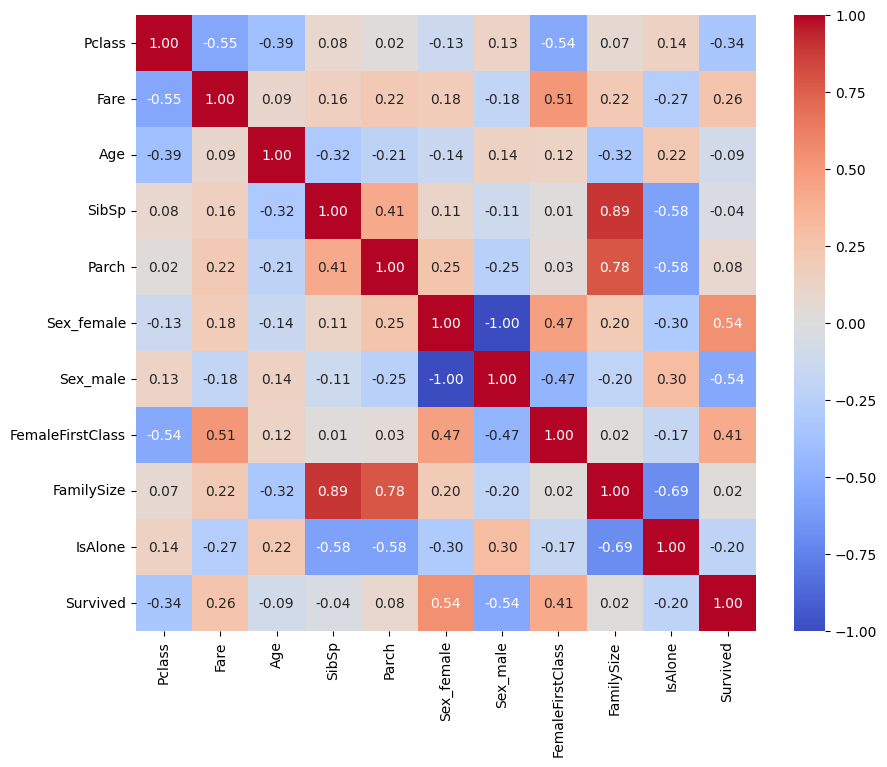

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

full_data = pd.concat([training_X2, training_Y], axis = 1, ignore_index=False) #This is all the data (including the features and labels)

#Making a correlation matrix
corr_matrix = full_data.corr()

#print(full_data)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Save the figure
plt.savefig('heatmap3.png')

plt.show()

**From the correlation Matrix and heatmap, I think I want to remove FamilySize, and just let SibSp and Parch do it's thing. I also want to add ChildFirstClass and isChild**

## Creating age bins using matplotlib and finding out which young ages are more likely to survive 

C:\Users\Micha\AppData\Local\Temp\ipykernel_13360\3698201998.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = df.groupby('AgeRange')['Survived'].mean()


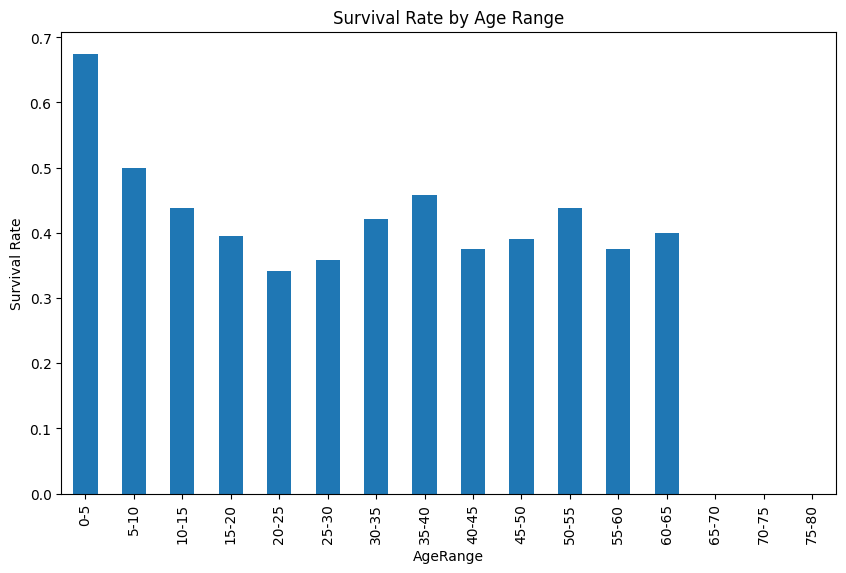

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")

# Assuming 'df' is your DataFrame and it has columns 'Age' and 'Survived'
# Create age ranges

bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '75-80']
df['AgeRange'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Calculate mean survival rate for each age range
age_survival = df.groupby('AgeRange')['Survived'].mean()

# Plot
age_survival.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Age Range')
plt.show()

C:\Users\Micha\AppData\Local\Temp\ipykernel_13360\1569054478.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = df.groupby('AgeRange')['Survived'].mean()


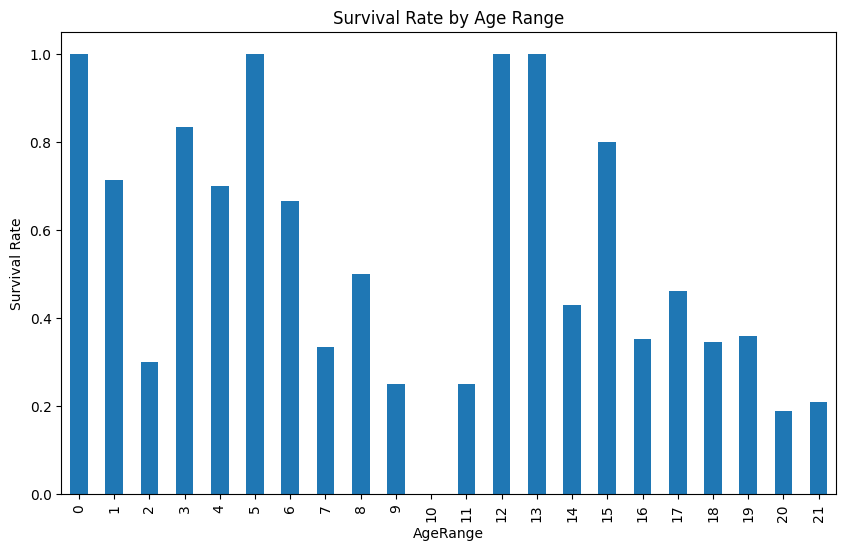

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")

# Create age ranges of 1 year for ages 0-22
bins = list(range(23))
labels = [str(i) for i in range(22)]
df['AgeRange'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Calculate mean survival rate for each age range
age_survival = df.groupby('AgeRange')['Survived'].mean()

# Plot
age_survival.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Age Range')
plt.show()

C:\Users\Micha\AppData\Local\Temp\ipykernel_13360\3826917345.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival = df.groupby('AgeRange')['Survived'].mean()


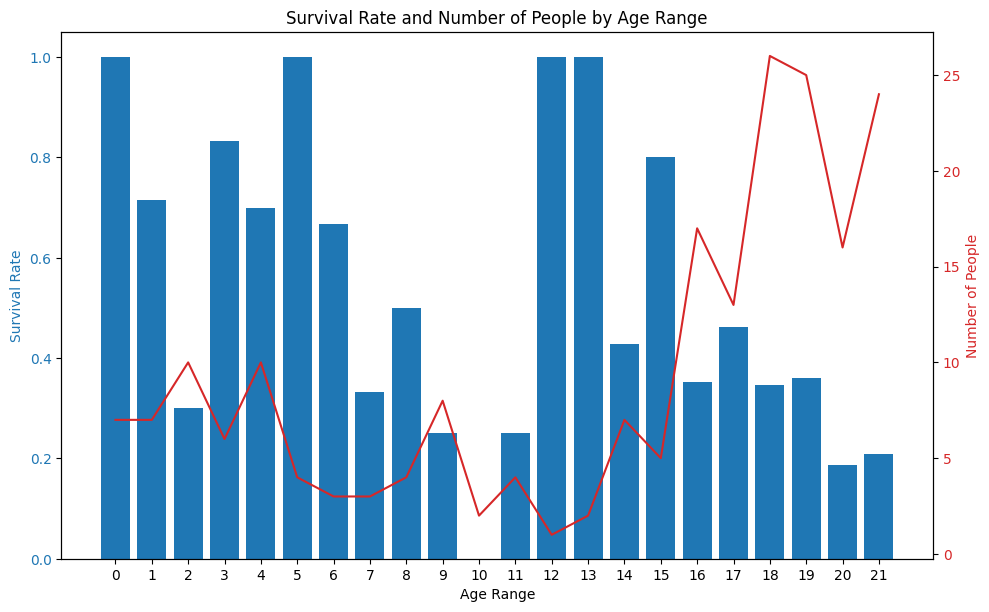

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")

# Create age ranges of 1 year for ages 0-22
bins = list(range(23))
labels = [str(i) for i in range(22)]
df['AgeRange'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Calculate mean survival rate for each age range
age_survival = df.groupby('AgeRange')['Survived'].mean()

# Calculate count of people in each age range
age_counts = df['AgeRange'].value_counts().sort_index()

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Age Range')
ax1.set_ylabel('Survival Rate', color=color)
ax1.bar(age_survival.index, age_survival, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Number of People', color=color)  # we already handled the x-label with ax1
ax2.plot(age_counts.index, age_counts, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Survival Rate and Number of People by Age Range')
plt.show()

## For model 13, I'm changing the threshhold for being a child from 18 to 15. I also want to add ChildFirstClass and isChild 

In [50]:
# import keras_tuner as kt

# def build_model(hp):
#     model = tf.keras.Sequential()
    
#     # Input layer
#     model.add(tf.keras.layers.Dense(
#         units=hp.Int('input_units', min_value=1, max_value=64, step=1),
#         activation=hp.Choice('input_activation', ['relu', 'tanh', 'sigmoid']),
#         input_shape=(train_X.shape[1],)
#     ))
    
#     # Hidden layers
#     for i in range(hp.Int('n_layers', 1, 5)):
#         model.add(tf.keras.layers.Dense(
#             units=hp.Int(f'hidden_units_{i}', min_value=1, max_value=64, step=1),
#             activation=hp.Choice(f'hidden_activation_{i}', ['relu', 'tanh', 'sigmoid']),
#             kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'regularization_{i}', min_value=0.0, max_value=0.1, step=0.01))
#         ))
#         # Dropout layer
#         model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    
#     # Output layer
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
#     # Compile the model
#     model.compile(
#         optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])
    
#     return model

# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=100,
#     directory='directory_for_model_13',  #Make sure to change ethe directory  and project name if you want to start a fresh new tuning session
#     project_name='keras_tuner_model13', # make sure to change the project and directory name if you want to start a fresh new tuning session
#     hyperband_iterations=2)  # Increase if you have more time

# # Search for the best hyperparameters
# tuner.search(pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_Y, valid_Y], ignore_index=True), 
#              epochs=100, 
#              validation_split=0.2,  # 20% of the data will be used for validation
#              batch_size=32)  # Fixed batch size

# # Get the best model
# best_model = tuner.get_best_models()[0]

# #This took 13 minutes


# # Hyperparameters: 
# # input_units 53
# # input_activation relu
# # n_layers 1
# # hidden_units_0 59
# # hidden_activation_0 tanh
# # regularization_0 0.01
# # dropout_rate 0.1
# # optimizer rmsprop
# # hidden_units_1 37
# # hidden_activation_1 relu
# # regularization_1 0.06
# # hidden_units_2 35
# # hidden_activation_2 sigmoid
# # regularization_2 0.01
# # hidden_units_3 63
# # hidden_activation_3 relu
# # regularization_3 0.04
# # hidden_units_4 11
# # hidden_activation_4 sigmoid
# # regularization_4 0.1
# # tuner/epochs 100
# # tuner/initial_epoch 34
# # tuner/bracket 3
# # tuner/round 3
# # tuner/trial_id 0205
# # Model Configuration: 
# # Visualizing the model: 
# # Weights and Biases: 
# # Optimizer: 
# # {'name': 'RMSprop', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': 100, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}

In [51]:
# #1 Summary of the model: This will print a summary of the model's layers, output shapes, and the number of parameters.
# print("Summary of Model: ")
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.summary()

# #2 Inspect Hyperparameters: This will display the values of the hyperparameters like the number of units in each layer, learning rate, etc.
# print("Hyperparameters: ")
# best_hp = tuner.get_best_hyperparameters()[0]
# for param in best_hp.values:
#     print(param, best_hp.get(param))

    
# #3 Model Configuration: This returns a Python dictionary containing the model configuration. It can be quite detailed and technical, showing layer types, activation functions, and other layer-specific settings.
# print("Model Configuration: ")
# config = best_model.get_config()


# #4 Visualizing the Model: This creates a plot of the model architecture, showing the layers, their shapes, and how they're connected.
# print("Visualizing the model: ")  # MAKE
# tf.keras.utils.plot_model(best_model, to_file='model13.png', show_shapes=True, show_layer_names=True) # MAKE SURE TO CHANGE THE FILE NAME 


# #5 Weights and Biases: This will print out the weights and biases for each layer in the model. Be cautious with large models, as this can be a lot of data.
# print("Weights and Biases: ")
# # for layer in best_model.layers:
# #     weights, biases = layer.get_weights()
# #     print(layer.name, weights, biases)


# #6 see the best optimizer specifically 
# print("Optimizer: ")
# # Get the optimizer's configuration
# optimizer_config = best_model.optimizer.get_config()

# # Print the optimizer configuration
# print(optimizer_config)


## Submitting Model 13. Score: 76

In [52]:
# # Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters()[0]

# # Rebuild the model with the best hyperparameters
# model13 = build_model(best_hp)   # I have to re-build the model since I have to re-fit on the whole training data (training_X2) 

# #Or, another thing you can do is just use the best model from the keras tuner instead of re-fitting it on the full training data 
# #model13 = best_model

# # Fit the model on the entire training dataset

# model13.fit(training_X2, training_Y, epochs=115, validation_split=0.2, verbose=0) # Before, I used to do epoch of 100 here, but I should do a slightly higher epoch since I am testing on more data (entire training dataset). I found for here, 115 is good

# if "PassengerId" in test_data2.columns:
#     test_data2 = test_data2.drop("PassengerId", axis = 1)

# model13.save("model_13_saved.h5") # This is saving the model in an H5 file. This makes sure that I never lose the model with these weights and everything else

# predictions = model13.predict(test_data2)

# predictions = (predictions > 0.5).astype("int32") # 0.5 and 0.52 got a score of 79.425. For rebuilt model, I got an 80.143 using 0.52 and 0.54 and 0.545. With epoch 115, I got 80.662 with 0.5

# original_test = pd.read_csv("test.csv")

# pass_id = original_test['PassengerId']

# test_data2["PassengerId"] = pass_id

# #Flatten out predictions so that we make sure it's a 1D array

# predictions = predictions.reshape(-1)

# output = pd.DataFrame({'PassengerId': test_data2.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

# test_data2 = test_data2.drop("PassengerId", axis = 1) # WE make sure to drop the PassengerId column since we are continuing to use the test_data variable in future tests and we don't want PassengerId to be apart of it until we submit the model again

## For model 14, I want to do the exact same thing as Model 12 (my best model yet), but I want to expand the range for the number of possible neurons per layer

In [53]:
# import keras_tuner as kt

# def build_model(hp):
#     model = tf.keras.Sequential()
    
#     # Input layer
#     model.add(tf.keras.layers.Dense(
#         units=hp.Int('input_units', min_value=1, max_value=70, step=1),
#         activation=hp.Choice('input_activation', ['relu', 'tanh', 'sigmoid']),
#         input_shape=(train_X.shape[1],)
#     ))
    
#     # Hidden layers
#     for i in range(hp.Int('n_layers', 1, 5)):
#         model.add(tf.keras.layers.Dense(
#             units=hp.Int(f'hidden_units_{i}', min_value=1, max_value=70, step=1),
#             activation=hp.Choice(f'hidden_activation_{i}', ['relu', 'tanh', 'sigmoid']),
#             kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'regularization_{i}', min_value=0.0, max_value=0.1, step=0.01))
#         ))
#         # Dropout layer
#         model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    
#     # Output layer
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
#     # Compile the model
#     model.compile(
#         optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])
    
#     return model

# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=100,
#     seed=42,   # MAKE SURE TO SET A SEED SO THAT YOU CONTROL RANDOMNESS
#     directory='directory_for_model_14',  #Make sure to change ethe directory  and project name if you want to start a fresh new tuning session
#     project_name='keras_tuner_model14', # make sure to change the project and directory name if you want to start a fresh new tuning session
#     hyperband_iterations=2)  # Increase if you have more time

# # Search for the best hyperparameters
# tuner.search(pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_Y, valid_Y], ignore_index=True), 
#              epochs=100, 
#              validation_split=0.2,  # 20% of the data will be used for validation
#              batch_size=32)  # Fixed batch size

# # Get the best model
# best_model = tuner.get_best_models()[0]

# # Best val_accuracy So Far: 0.8181818127632141
# # Total elapsed time: 00h 17m 48s

# # Model: "sequential"
# # _________________________________________________________________
# #  Layer (type)                Output Shape              Param #   
# # =================================================================
# #  dense (Dense)               (None, 67)                737       
                                                                 
# #  dense_1 (Dense)             (None, 59)                4012      
                                                                 
# #  dropout (Dropout)           (None, 59)                0         
                                                                 
# #  dense_2 (Dense)             (None, 19)                1140      
                                                                 
# #  dropout_1 (Dropout)         (None, 19)                0         
                                                                 
# #  dense_3 (Dense)             (None, 47)                940       
                                                                 
# #  dropout_2 (Dropout)         (None, 47)                0         
                                                                 
# #  dense_4 (Dense)             (None, 24)                1152      
                                                                 
# #  dropout_3 (Dropout)         (None, 24)                0         
                                                                 
# #  dense_5 (Dense)             (None, 52)                1300      
                                                                 
# #  dropout_4 (Dropout)         (None, 52)                0         
                                                                 
# #  dense_6 (Dense)             (None, 1)                 53        
                                                                 
# # =================================================================
# # Total params: 9334 (36.46 KB)
# # Trainable params: 9334 (36.46 KB)
# # Non-trainable params: 0 (0.00 Byte)
# # _________________________________________________________________
# # Hyperparameters: 
# # input_units 67
# # input_activation relu
# # n_layers 5
# # hidden_units_0 59
# # hidden_activation_0 tanh
# # regularization_0 0.0
# # dropout_rate 0.0
# # optimizer adam
# # hidden_units_1 19
# # hidden_activation_1 tanh
# # regularization_1 0.04
# # hidden_units_2 47
# # hidden_activation_2 relu
# # regularization_2 0.0
# # hidden_units_3 24
# # hidden_activation_3 tanh
# # regularization_3 0.01
# # hidden_units_4 52
# # hidden_activation_4 tanh
# # regularization_4 0.03
# # tuner/epochs 100
# # tuner/initial_epoch 34
# # tuner/bracket 4
# # tuner/round 4
# # tuner/trial_id 0142
# # Model Configuration: 
# # Visualizing the model: 
# # Weights and Biases: 
# # Optimizer: 
# # {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [54]:
# #1 Summary of the model: This will print a summary of the model's layers, output shapes, and the number of parameters.
# print("Summary of Model: ")
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.summary()

# #2 Inspect Hyperparameters: This will display the values of the hyperparameters like the number of units in each layer, learning rate, etc.
# print("Hyperparameters: ")
# best_hp = tuner.get_best_hyperparameters()[0]
# for param in best_hp.values:
#     print(param, best_hp.get(param))

    
# #3 Model Configuration: This returns a Python dictionary containing the model configuration. It can be quite detailed and technical, showing layer types, activation functions, and other layer-specific settings.
# print("Model Configuration: ")
# config = best_model.get_config()


# #4 Visualizing the Model: This creates a plot of the model architecture, showing the layers, their shapes, and how they're connected.
# print("Visualizing the model: ")  # MAKE
# tf.keras.utils.plot_model(best_model, to_file='model14.png', show_shapes=True, show_layer_names=True) # MAKE SURE TO CHANGE THE FILE NAME 


# #5 Weights and Biases: This will print out the weights and biases for each layer in the model. Be cautious with large models, as this can be a lot of data.
# print("Weights and Biases: ")
# # for layer in best_model.layers:
# #     weights, biases = layer.get_weights()
# #     print(layer.name, weights, biases)


# #6 see the best optimizer specifically 
# print("Optimizer: ")
# # Get the optimizer's configuration
# optimizer_config = best_model.optimizer.get_config()

# # Print the optimizer configuration
# print(optimizer_config)


## Submitting Model 14. Score 78.229

In [55]:
# from sklearn.model_selection import train_test_split

# # Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters()[0]

# # Rebuild the model with the best hyperparameters
# model14 = build_model(best_hp)   # I have to re-build the model since I have to re-fit on the whole training data (training_X2) 

# #Or, another thing you can do is just use the best model from the keras tuner instead of re-fitting it on the full training data 
# #model14 = best_model

# # Fit the model on the entire training dataset

# model14.fit(training_X2, training_Y, epochs=115, validation_split=0.2, verbose=0) # Before, I used to do epoch of 100 here, but I should do a slightly higher epoch since I am testing on more data (entire training dataset). I found for here, 115 is good

# if "PassengerId" in test_data2.columns:
#     test_data2 = test_data2.drop("PassengerId", axis = 1)

# model14.save("model_14_saved.h5") # This is saving the model in an H5 file. This makes sure that I never lose the model with these weights and everything else

# predictions = model14.predict(test_data2)

# predictions = (predictions > 0.6).astype("int32") # 0.5 and 0.52 got a score of 79.425. For rebuilt model, I got an 80.143 using 0.52 and 0.54 and 0.545. With epoch 115, I got 80.662 with 0.5

# original_test = pd.read_csv("test.csv")

# pass_id = original_test['PassengerId']

# test_data2["PassengerId"] = pass_id

# #Flatten out predictions so that we make sure it's a 1D array

# predictions = predictions.reshape(-1)

# output = pd.DataFrame({'PassengerId': test_data2.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

# test_data2 = test_data2.drop("PassengerId", axis = 1) # WE make sure to drop the PassengerId column since we are continuing to use the test_data variable in future tests and we don't want PassengerId to be apart of it until we submit the model again

## SelectKBest is a good tool to see what features are good to include

In [56]:
from sklearn.feature_selection import SelectKBest, f_classif


# Create the SelectKBest with the f_classif function. You can set the parameter "k" equal to a number if you want to limit the amount of features
selector = SelectKBest(f_classif)

# Fit the selector to the data
selector.fit(training_X2, training_Y)

# Get the boolean mask of the selected features
mask = selector.get_support()

# Get the names of the selected features
selected_features = training_X.columns[mask]

print(selected_features)



# Get the scores
scores = selector.scores_

# Create a DataFrame with the scores
features_scores = pd.DataFrame({'Feature': training_X2.columns, 'Score': scores})

# Sort the DataFrame by score in descending order
features_scores = features_scores.sort_values(by='Score', ascending=False)

print(features_scores)


Index(['Pclass', 'Fare', 'Age', 'SibSp', 'Parch', 'Sex_female', 'Sex_male',
       'FemaleFirstClass', 'FamilySize', 'IsAlone'],
      dtype='object')
            Feature       Score
5        Sex_female  372.405731
6          Sex_male  372.405731
7  FemaleFirstClass  182.372589
0            Pclass  115.031143
1              Fare   63.030792
9           IsAlone   38.353794
2               Age    7.389521
4             Parch    5.963451
3             SibSp    1.110565
8        FamilySize    0.246159


In [57]:
import tensorflow as tf

print(tf.__version__)

2.15.0


In [58]:
# import tensorflow_decision_forests as tfdf

# import tensorflow as tf

# print(tf.__version__)
# # Load a dataset
# train_df = pd.read_csv("train.csv")

# # Convert the pandas dataframe to a tensorflow dataset
# train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, task=tfdf.keras.Task.CLASSIFICATION)

# # Train the model
# model = tfdf.keras.RandomForestModel()
# model.fit(train_data)

## Recursive feature elimination (from scikit learn) is another great tool to see what the best features are 

## Find a way to remove FamilySize without affect isChild. And make sure you don't make it too complicated incase you want to add back FamilySize

## Another thing I want to do is try different techniques to find the best features. And this time, I want to include EVERY feature, including the feature engineering

## When you do kerastuner, make sure to change the "project name" attribute and maybe even the "directory" attribute since this indicates that you are making a fresh new keras tuner

**Play around with the threshold some more and then also try adding/removing some more feature engineering. Also try playing with the epochs on the fitting and also whether to build new model or use the one from keras.**

**After that, use advanced techniques to try to find the best features**

**1. Another thing i want to try is seeing if removing some of the feature enginering will help, since I removed some in the randomforestclassifier and it improved the model**

**2. Another thing to look into is the kernel_initializer since those are how the model finds the initial value for the weights in each layer so look into that**

**4. Try Keras Tuner with the Bayesian Optimizer instead of hyperband**

**5. Earlier, I use a random forest classifier to fill in the missing data for whether someone was a male or female. Maybe try optimizing that or just removing the rows of data for which gender is missing. Maybe do the same for the other columns with missing values**

**7. Try Random forest classifier on tensor flow. Also try XGBoost**

**8. Maybe try optimizing the age imputer using tensorflow neural network or random forest classifier**

**9. Try looking into different ways to see which features are best to choose from, like using correlation matrix or Scikit learn SelectKBest**

**10. Research more about the pipeline and see if you can use it. Also, research about the XGBoost**